In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.random.seed(123)
import pandas as pd
import nibabel as nib
import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from matplotlib import pyplot as plt
from matplotlib import cm
from keras import backend as K
from keras_fcn import FCN
#from keras_contrib.applications.densenet import DenseNet, DenseNetFCN
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import Conv2D, Input
from keras.layers import Reshape, Dropout
from keras.layers import RepeatVector
from keras.layers import Activation, BatchNormalization
from keras.layers import concatenate, GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [3]:
def get_file_data(file):
    file_img = nib.load(file)
    file_affine = file_img.get_affine()
    file_data = file_img.get_data()
    return file_data, file_affine

def save_image(file_data, file_affine, file_name):
    image = nib.Nifti1Image(file_data, file_affine)
    image.to_filename(file_name)
    return

# Load images (X)
# Reshape, convert to float, normalize between 0 and 1
def load_images(image_folder):
    images = sorted(glob.glob(image_folder+'/*'))
    num_images = len(images)
    test_data, test_aff = get_file_data(images[0])
    img_x, img_y = test_data.shape
    X = np.zeros((num_images, img_x, img_y, 1))
    for i, image in enumerate(images):
        data, aff = get_file_data(image)
        X[i,:,:,0] = data
    X = X.astype('float32')
    max_X = np.amax(X)
    X /= max_X 
    return X

# Load clinical metrics (Y)
# Convert to categorical variable array
def load_clinical_metrics(csv_file, metric_name):
    df = pd.read_csv(csv_file)
    metric = df[metric_name]
    Y = metric.values
    num_categories = len(np.unique(Y))
    Y = np_utils.to_categorical(Y, num_categories)
    return Y

In [4]:
smooth_factor = 1.0

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_factor) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_factor)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [5]:
def get_model():
    drop_rate_concat = 0.4
    drop_rate_hidden = 0.4
    bn_momentum = 0.1
    
    inputs = Input((30, 30, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    
    # Rate 2
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',padding='same', name="rate2_1")(conv1)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same', name="rate2_2")(conv3)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    
    ############ Branches for ASPP
    
    # Branch for 1x1
    conv3a = Conv2D(32, (3, 3), activation='relu', padding='same', name="branch1x1_1")(conv3)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    conv3a = Conv2D(32, (1, 1), activation='relu', padding='same', name="branch1x1_2")(conv3a)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    
    # Branch for 3x3 rate 6
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', name="rate6_1")(conv3)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', name="rate6_2")(conv4)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    
    # Branch for 3x3 rate 12
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu', padding='same', name="rate12_1")(conv3)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu', padding='same', name="rate12_2")(conv5)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    
    # Branch for 3x3 rate 18
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu', padding='same', name="rate18_1")(conv3)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu', padding='same', name="rate18_2")(conv6)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    
    # Branch for 3x3 rate 24
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu', padding='same', name="rate24_1")(conv3)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu', padding='same', name="rate24_2")(conv7)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    
    # Branch for the global context
    global_pool = GlobalAveragePooling2D()(conv1)
    global_pool = RepeatVector(30*30)(global_pool)
    global_pool = Reshape((30, 30, 32))(global_pool)
    
    ############# Concatenation 
    concat = concatenate([conv3a, conv4, conv5, conv6, global_pool, conv7], axis=3)
    concat = BatchNormalization(momentum=bn_momentum)(concat)
    concat = Dropout(drop_rate_concat)(concat)
    
    amort = Conv2D(64, (1, 1), activation='relu', padding='same', name="amort")(concat)
    amort = BatchNormalization(momentum=bn_momentum)(amort)
    amort = Dropout(drop_rate_hidden)(amort)

    predictions = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name="predictions")(amort)

    model = Model(inputs=[inputs], outputs=[predictions])
    return model

In [6]:
X = load_images('/data/henry6/esha/CNN/low_res_img_data')
X.shape

Y = load_images('/data/henry6/esha/CNN/low_res_gm_mask_data')
Y = Y.astype('int')

# Split into test and training groups
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train,test_size=.1)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

/home/edatta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  app.launch_new_instance()


(120, 30, 30, 1)
(14, 30, 30, 1)
(15, 30, 30, 1)


In [7]:
model = get_model()
opt = Adam(lr=0.001)

model.compile(optimizer=opt,
              loss=dice_coef_loss,
              metrics=["accuracy"])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 30, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 30, 30, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 30, 30, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 30, 30, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
checkpt = ModelCheckpoint('best_weight.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience = 5, verbose=0, mode='auto')
callbacks = [checkpt, early]
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, nb_epoch=100, verbose=1, shuffle=True, callbacks=callbacks)

/home/edatta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 120 samples, validate on 14 samples
Epoch 1/100
120/120 [==============================] - 4s - loss: -0.1809 - acc: 0.7989 - val_loss: -0.2722 - val_acc: 0.8759
Epoch 2/100
120/120 [==============================] - 4s - loss: -0.2008 - acc: 0.8279 - val_loss: -0.2626 - val_acc: 0.8716
Epoch 3/100
120/120 [==============================] - 4s - loss: -0.2207 - acc: 0.8493 - val_loss: -0.2724 - val_acc: 0.8776
Epoch 4/100
120/120 [==============================] - 4s - loss: -0.2399 - acc: 0.8660 - val_loss: -0.2766 - val_acc: 0.8836
Epoch 5/100
120/120 [==============================] - 5s - loss: -0.2581 - acc: 0.8799 - val_loss: -0.2874 - val_acc: 0.8905
Epoch 6/100
120/120 [==============================] - 4s - loss: -0.2758 - acc: 0.8916 - val_loss: -0.3004 - val_acc: 0.9013
Epoch 7/100
120/120 [==============================] - 4s - loss: -0.2932 - acc: 0.9018 - val_loss: -0.3152 - val_acc: 0.9094
Epoch 8/100
120/120 [==============================] - 4s - loss: -0.3107

In [12]:
Y_predict = model.predict_on_batch(X_test)
Y_predict_prob = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
score

15/15 [==============================] - 0s


[-0.80335742235183716, 0.98725926876068115]

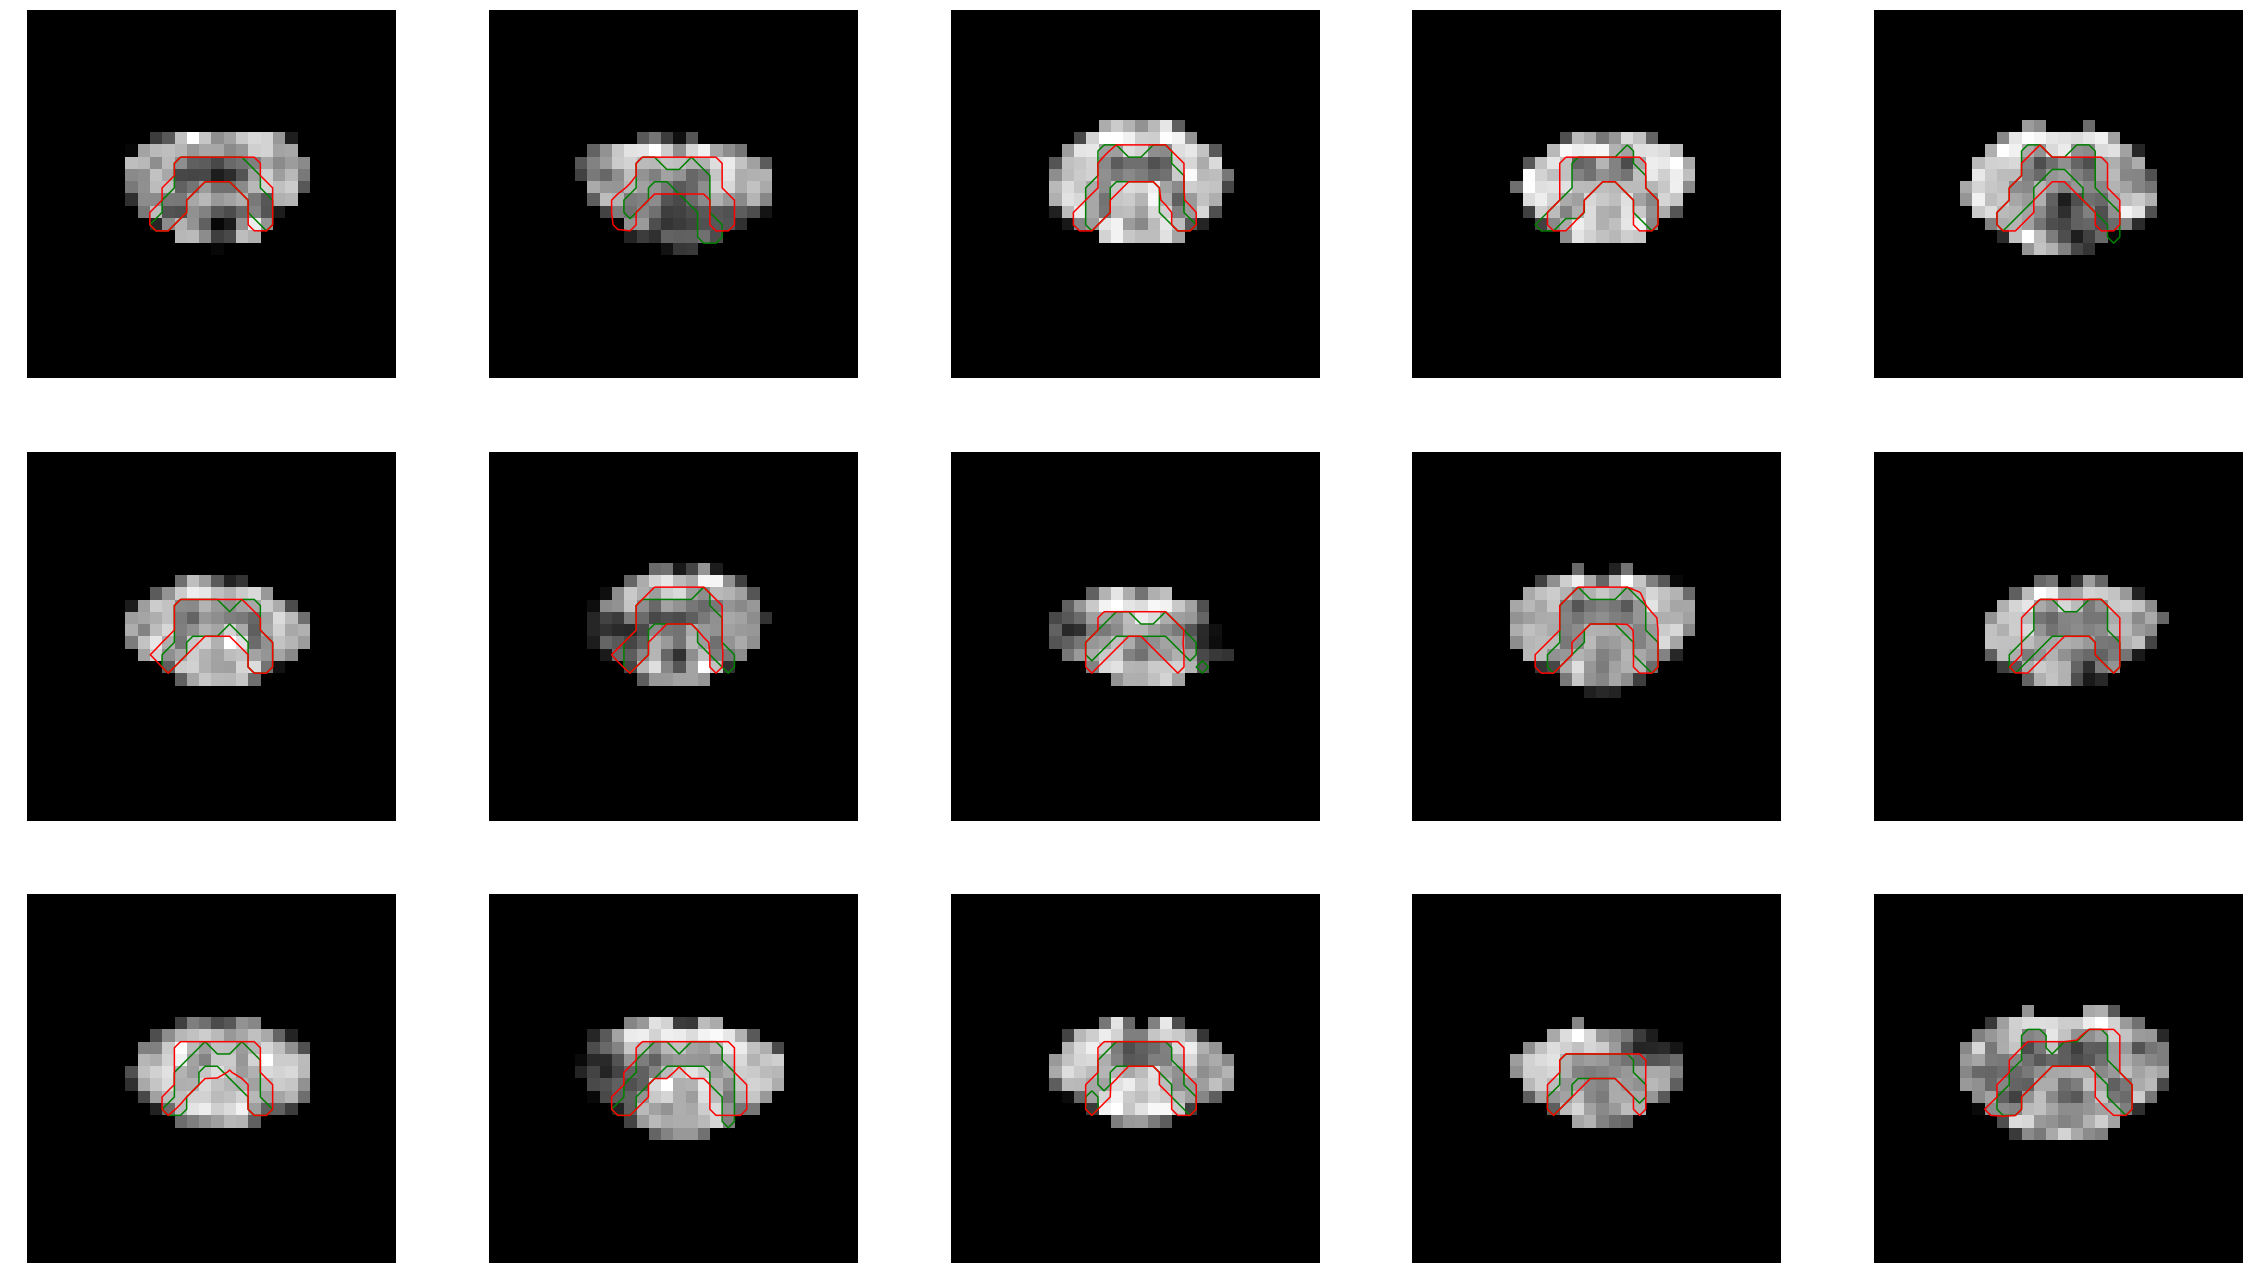

In [13]:
plt.figure(figsize=(40,80)) 
fig = plt.gcf()
for img_num in xrange(len(X_test)):
    img = X_test[img_num,:,:,0]
    mask = Y_test[img_num,:,:,0]
    predicted_mask = Y_predict[img_num,:,:,0]
    ax = fig.add_subplot(10,5,img_num+1)
    ax.axis('off')
    cordmin = np.amin(img[img!=0])
    cordmax = np.amax(img[img!=0])
    ax.imshow(np.flipud(np.transpose(img)), cmap=cm.gray, vmin=cordmin, vmax=cordmax)
    ax.contour(np.flipud(np.transpose(mask)), [0.5], colors='g')
    #ax.imshow(np.flipud(np.transpose(predicted_mask)))
    ax.contour(np.flipud(np.transpose(predicted_mask)), [0.5], colors='r')